In [13]:
# Pytorch] MLP 설계 연습, MNIST이용

# 순서
'''
1. 모듈 임포트하기
2. 딥러닝 모델 설계할때 사용할 장비 확인 (  ? )
3. MNIST 데이터 다운, Train,Test 셋 분리
4. 데이터 확인
5. MLP 설계하기 
6. Optimizer, Objective Function 설정하기
7. MLP모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의하기 
8. 학습되는 과정 속에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의하기
9. MLP학습을 실행하면서 Train, Test set의 Loss, Test set Accuarcy확인하기
'''
# 1
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms, datasets

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
  
print('Using Pytorch Version:', torch.__version__, 'Device:', DEVICE)
# Pytorch version 1.9.0 , cu102

Using Pytorch Version: 1.9.0+cu102 Device: cpu


In [14]:
BATCH_SIZE = 32
EPOCHS = 10 

train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train=True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


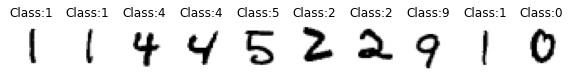

In [15]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class:' + str(y_train[i].item()))
  

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,10)

  def forward(self,x):
    x = x.view(-1, 28*28)
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x


In [27]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [28]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print("train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100.*batch_idx/len(train_loader),
          loss.item()))
      

In [29]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [30]:
for Epoch in range(1,EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuarcy: {:.2f}%\n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Epoch: 1 [0/60000(0%)]	Train Loss: 2.276194
train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.290925
train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.310669
train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.292722
train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.256329
train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.290349
train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.258722
train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.255940
train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.257387
train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.222601

[EPOCH: 1], 	Test Loss: 0.0698, 	Test Accuarcy: 12.12%

train Epoch: 2 [0/60000(0%)]	Train Loss: 2.279059
train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.217277
train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.172526
train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.038756
train Epoch: 2 [25600/60000(43%)]	Train Loss: 1.978213
train Epoch: 2 [32000/60000(53%)]	Train Loss: 1.820429
train Epoch: 2 [38400/60000(64%)]	Train Loss: 1.790819
train Epoch: 2 [4480